In [ ]:
!pip install -q pyclipper
!pip install -q Polygon3

     |████████████████████████████████| 603 kB 28.0 MB/s 


In [ ]:
!cp "./drive/MyDrive/shared/zerowaste-f-final.zip" ./
!unzip -q "./zerowaste-f-final.zip"

import os
os.mkdir("./images")
os.mkdir("./labels")

In [ ]:
import os
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt
import Polygon as plg
import pyclipper

from PIL import Image


# set plot size
def set_plot_size(name):
    # (w, h)
    if name == "wide":
        plt.rcParams["figure.figsize"] = (30, 4)
        return
    if name == "big":
        plt.rcParams["figure.figsize"] = (30, 10)  # (w, h)
        return
    plt.rcParams["figure.figsize"] = (6, 4)  # normal


# ----- #
# from PSENet
# ----- #
def dist(a, b):
    return np.linalg.norm((a - b), ord=2, axis=0)


def perimeter(bbox):
    peri = 0.0
    for i in range(bbox.shape[0]):
        peri += dist(bbox[i], bbox[(i + 1) % bbox.shape[0]])
    return peri


def shrink(bboxes, rate, max_shr=40):
    rate = rate * rate
    shrinked_bboxes = []
    for bbox in bboxes:
        area = plg.Polygon(bbox).area()
        peri = perimeter(bbox)

        try:
            pco = pyclipper.PyclipperOffset()
            pco.AddPath(bbox, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
            offset = min(int(area * (1 - rate) / (peri + 0.001) + 0.5), max_shr)

            shrinked_bbox = pco.Execute(-offset)
            if len(shrinked_bbox) == 0:
                shrinked_bboxes.append(bbox)
                continue

            shrinked_bbox = np.array(shrinked_bbox[0])
            if shrinked_bbox.shape[0] <= 2:
                shrinked_bboxes.append(bbox)
                continue

            shrinked_bboxes.append(shrinked_bbox)
        except Exception as e:
            print('area:', area, 'peri:', peri)
            shrinked_bboxes.append(bbox)

    return shrinked_bboxes

In [ ]:
# ----- #
# get data_dict_all
# ----- #
def json2dict(path):
    with open(path) as f:
        return json.load(f)
     
        
labels_train = json2dict("./splits_final_deblurred/train/labels.json")

img_all = labels_train["images"]
anno_raw = labels_train["annotations"]
anno_all = [list() for idx in range(3002)]

for idx in range(len(anno_raw)):
    tmp = anno_raw[idx]
    idx_img = tmp["image_id"]
    anno_all[idx_img].append(tmp)


def get_zerowaste_dicts():
    dataset_dicts = []
    for idx0 in range(len(img_all)):
        record = dict()
        tmp = img_all[idx0]
        record["file_name"] = os.path.join("./splits_final_deblurred/train/data", tmp["file_name"])
        record["image_id"] = tmp["id"]
        record["width"] = tmp["width"]
        record["height"] = tmp["height"]
        
        tmp_tmp = anno_all[idx0]
        objs = list()
        for item in tmp_tmp:
            obj = dict()
            obj["bbox"] = item["bbox"]
            obj["bbox_mode"] = "XYWH_ABS"
            obj["segmentation"] = item["segmentation"]
            obj["category_id"] = item["category_id"] - 1
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


data_dict_all = get_zerowaste_dicts()

In [ ]:
def label_generation_operation_1(data_dict_all, idx):
    data_dict = data_dict_all[idx]
    anno_all = data_dict["annotations"]

    canvas = np.zeros((1080, 1920, 3), dtype="float32")
    for counter, anno in enumerate(anno_all):
        contours = anno["segmentation"][0]
        contours = np.array(contours).reshape((-1, 2))
        contours = np.round(contours).astype("int32")
        contours = [contours]   

        category_id = anno["category_id"]     

        # 0
        canvas[..., 0] = cv2.drawContours(canvas[..., 0].copy(), contours, 0, category_id + 1, -1)

        # 1
        canvas[..., 1] = cv2.drawContours(canvas[..., 1].copy(), shrink(contours, 0.75), 0, 1, -1)

        # 2
        canvas[..., 2] = cv2.drawContours(canvas[..., 2].copy(), shrink(contours, 0.5), 0, 1, -1)            
    return canvas


def label_generation_operation_2(canvas):
    canvas_1 = np.zeros((1080, 1920, 4), dtype="float32")
    canvas_2 = canvas[..., 0].copy()
    canvas_3 = (canvas[..., 0] != 0)[..., None]
    canvas_4 = canvas[..., 1:]

    canvas_1[canvas_2 == 1, 0] = 1
    canvas_1[canvas_2 == 2, 1] = 1
    canvas_1[canvas_2 == 3, 2] = 1
    canvas_1[canvas_2 == 4, 3] = 1

    canvas_out = np.concatenate((canvas_1, canvas_3, canvas_4), axis=2)
    return canvas_out



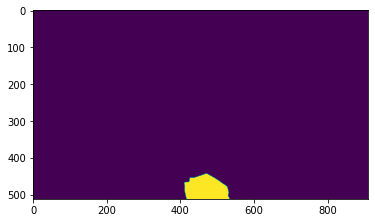

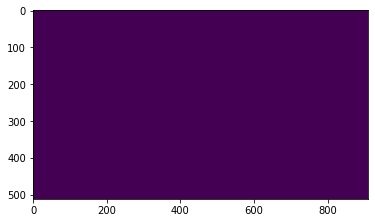

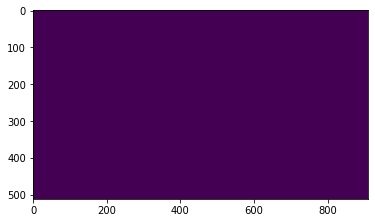

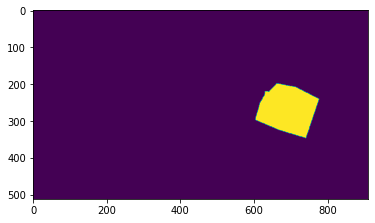

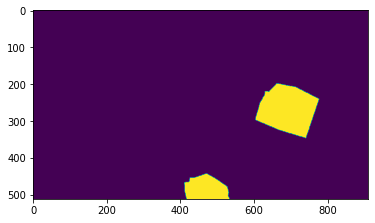

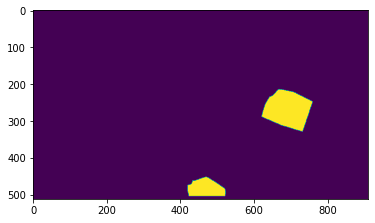

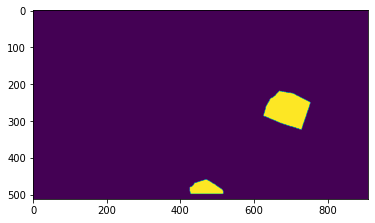

In [ ]:
idx = np.random.randint(3002)
data_dict = data_dict_all[idx]
path_img = data_dict["file_name"]

canvas = label_generation_operation_1(data_dict_all, idx)
canvas = label_generation_operation_2(canvas)
canvas = cv2.resize(canvas, (910, 512))
canvas = canvas.astype("bool")

set_plot_size("small")
plt.imshow(canvas[..., 0])
plt.show()
plt.imshow(canvas[..., 1])
plt.show()
plt.imshow(canvas[..., 2])
plt.show()
plt.imshow(canvas[..., 3])
plt.show()
plt.imshow(canvas[..., 4])
plt.show()
plt.imshow(canvas[..., 5])
plt.show()
plt.imshow(canvas[..., 6])
plt.show()

In [ ]:
for idx in range(3002):
    name = str(idx).zfill(5)

    data_dict = data_dict_all[idx]
    path_img = data_dict["file_name"]
    Image.open(path_img).resize((910, 512)).save("./images/" + name + ".jpg")

    canvas = label_generation_operation_1(data_dict_all, idx)
    canvas = label_generation_operation_2(canvas)
    canvas = cv2.resize(canvas, (910, 512))
    canvas = canvas.astype("bool")
    np.savez_compressed("./labels/" + name, canvas.astype("bool"))

    if (idx + 1) % 100 == 0:
        print(idx)


99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999


In [ ]:
!zip -rq "./images_train.zip" "./images"
!zip -rq "./labels_train.zip" "./labels"

!cp "./images_train.zip" "./drive/MyDrive/cs523_project/"
!cp "./labels_train.zip" "./drive/MyDrive/cs523_project/"